In [1]:
import os
import time
import errno
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import mean
from log_parser import log_parser
from mpl_toolkits.mplot3d import Axes3D

# Settings of Jupyter notebook HTML

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width: 100% !important; }</style>"))
display(HTML("<style>.container { font-size: 9.5px; !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 15px; color: red; }</style>"))
display(HTML("<style>.rendered_markdown { color: red; }</style>"))

# Initialization
### Pathes

In [2]:
default_file_name = 'dumpState.log'
file_name = 'G981V_TIE_3GMEM_30CPU_dumpstate_bottleneck_hint.txt'

#lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState_1593794288665.log')
lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/{}'.format(default_file_name))

NameError: name 'log_parser' is not defined

### Values

In [4]:
pData1 = [
    'MEMORY INFO', 
    'MEMSIZE INFO', 
    'SERVICE CRITICAL cpuinfo',
    'SERVICE CRITICAL SurfaceFlinger',
    'compressed core&heap dump',
    'SYSTEM LOG',
    'EVENT LOG',
    'KERNEL LOG',
    'LAST KMSG',
    'AP RESET INFO',
    'FILESYSTEMS & FREE SPACE',
    'SERVICE content',
    'SERVICE dropbox',
    'SERVICE accessibility',
    'SERVICE batterystats',
    'SERVICE HIGH meminfo',
    'SERVICE package',
    'SERVICE binder_calls_stats',
    'SERVICE wifi',
    'SERVICE procstats',
    'OLOG',
    'ACTIVITY MANAGER MARs',
    'ACTIVITY MANAGER PENDING INTENTS',
    'ACTIVITY MANAGER BROADCAST STATE',
    'ACTIVITY MANAGER LMK KILLS',
    'STORAGE BUFFER',
    'SYSTEM PROPERTIES',
    'CPU INFO',
    'VM TRACES JUST NOW',
    'MMC blk0 error',
    'DUMP OF SERVICE connmetrics',
    'DUMP OF SERVICE gfxinfo',
    'DUMP OF SERVICE display',
    'DUMP OF SERVICE telephony.registry',
    'LOG STATISTICS',
    'TSP RAW DATA',
]

lp.run(arg1=pData1)

#display(ssrm.file_lines)

### Functions

In [5]:
def grep(lines, searchers, n=99999, show=True):
    result = list()
    number_of_lines = 0

    for line in lines:
        if len(line) > 0:
            for searcher in searchers:
                if re.search(searcher, line):
                    number_of_lines = n
            if number_of_lines > 0:
                if show:
                    print(line.strip())
                result.append(line.strip())
                number_of_lines -= 1
                #if number_of_lines == 0:
                    #print("\n")
                    #result.append('')
                    
    if len(result) == 0:
        print("--- Nothing ---")
        
    return result

In [6]:
def pickedup(src, searcher, index=0):
    separators = ['/', ',', ' ']
    
    if searcher not in src:
        return None
    
    splited = src.split(searcher)
    if splited <= 0:
        return None
    
    numbers = re.findall('\d+', splited[1])
    if len(numbers) > index:
        return int(numbers[index])
    
    return None

In [7]:
def DictFromPickedUp(src, searchers):
    result = dict()
    for key in searchers.keys():
        result[key] = list()

    tmp = dict()
    for line in src:
        flag = False
        for key in searchers.keys():
            tmp[key] = pickedup(line, key, searchers[key])
            if tmp[key] is None:
                flag = True

        if flag == True:
            continue

        for key in searchers.keys():
            result[key].append(tmp[key])
            
    return result

In [8]:
def orderbyeq(src, index=0):
    result = dict()
    items = re.split('[ ]', src)
    for item in items:
        if '=' in item and item[0] == '[':
            item = item[1:]
            splited = item.split('=')
            key = splited[0]
            numbers = re.findall('\d+', splited[1])
            if numbers > 0:
                result[key] = int(numbers[0])
                
    return result

In [9]:
def DataframeFromDictSortByCount(rawdata):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    df['count'] = df.count(axis=1, numeric_only=True)
    df = df.sort_index(by='count', axis=0, ascending=False)
    df = df.drop(columns=['count'])    
    return df

In [10]:
def PlotFromDict(rawdata, threshold, title='', ylabel=''):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    for key in df.index:
        if max(rawdata[key]) > threshold:
            s = pd.Series(rawdata[key])
            ax = s.plot(figsize=(30,5), label=key, legend=True)
            ax.axhline(y=threshold, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
            ax.set_title(title)
            ax.set_ylabel(ylabel)

In [11]:
def MarkupLCDON(lines):
    LCD_ON = list()
    marker = ''
    for line in lines:
        if re.search('LCD', line):
            if re.search(' ON ', line):
                LCD_ON.append(line)
                marker = ' LCDON >>> '
                print(line)
            elif re.search(' OFF ', line):
                LCD_ON.append(line)
                marker = ''
                print(line)
        else:
            LCD_ON.append(marker + line)
            print(marker + line)
    return LCD_ON

In [12]:
def str2num(string):
    try:
        number = int(string)
    except:
        number = -1
        
    return number

def GetTime(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    Date = (Month * Days[Month] + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetKernelTime(line):
    splited = line.split('[')
    splited = splited[1].split(']')
    splited = splited[0].split('.')

    second = str2num(splited[0])
    if second < 0:
        return -1
    
    nanosecond = str2num(splited[1])
    if nanosecond < 0:
        return -1
    
    return (int)(second * 1000 + (int)(nanosecond / 1000))

# <span style="color:blue">Base</span> 

In [13]:
lines = lp.log_sections['SERVICE content']
tmp = grep(lines,['Uptime'], 1)

Uptime: 12m39s


In [14]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['mDefaultViewport'], 1)

--- Nothing ---


In [15]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['dumpstate: begin', 'dumpstate: done'], 1)

10-12 20:35:02.582  root 32070 32070 I dumpstate: begin


* 16xxxxxx ns : 60 hz 
* 8xxxxxx ns : 120 hz

In [16]:
lines = lp.log_sections['compressed core&heap dump']
tmp = grep(lines,['VSYNC period'], 1)
lines = lp.log_sections['SERVICE CRITICAL SurfaceFlinger']
tmp = grep(lines,['VSYNC period'], 1)

present offset:         0 ns	     VSYNC period:  16666666 ns
--- Nothing ---


* the number of installed packages

In [17]:
lines = lp.log_sections['ACTIVITY MANAGER MARs']
tmp = grep(lines,['mManagedPackage'], 1)

mManagedPackages --- size 101


In [18]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['debug_level'], 1)

[ro.boot.debug_level]: [0x4f4c]
[ro.debug_level]: [0x4f4c]
[ro.vendor.boot.debug_level]: [0x4f4c]


* Calculation for gap between android time and kernel time.

In [19]:
lines = lp.log_sections['KERNEL LOG']
sync_logs = grep(lines,['@Sync'], 1, show=True)

gapoftime = list()
for sync_log in sync_logs:
    androidtime = GetTime(sync_log)
    kerneltime = GetKernelTime(sync_log)

    if androidtime < 0 or kerneltime < 0:
        continue

    print("{} - {} = {}").format(androidtime, kerneltime, androidtime - kerneltime)
    gapoftime.append(androidtime - kerneltime)

GAP_OF_TIME = int(mean(gapoftime) + 0.5)
#display(gapoftime)
display("Average : {}".format(GAP_OF_TIME))
GAP_OF_TIME = gapoftime[0]
display("Current : {}".format(GAP_OF_TIME))

<6>[  367.159482]  [7:       watchdog: 1124] !@Sync 12 [2020-10-12 20:29:22.786] FD count : 844, wdog_way : softdog
<6>[  397.169681]  [1:       watchdog: 1124] !@Sync 13 [2020-10-12 20:29:52.796] FD count : 845, wdog_way : softdog
<6>[  427.180029]  [0:       watchdog: 1124] !@Sync 14 [2020-10-12 20:30:22.806] FD count : 850, wdog_way : softdog
<6>[  457.182863]  [7:       watchdog: 1124] !@Sync 15 [2020-10-12 20:30:52.810] FD count : 847, wdog_way : softdog
<6>[  487.184655]  [7:       watchdog: 1124] !@Sync 16 [2020-10-12 20:31:22.812] FD count : 852, wdog_way : softdog
<6>[  517.192096]  [1:       watchdog: 1124] !@Sync 17 [2020-10-12 20:31:52.819] FD count : 851, wdog_way : softdog
<6>[  547.196382]  [6:       watchdog: 1124] !@Sync 18 [2020-10-12 20:32:22.823] FD count : 851, wdog_way : softdog
<6>[  577.204663]  [0:       watchdog: 1124] !@Sync 19 [2020-10-12 20:32:52.831] FD count : 850, wdog_way : softdog
<6>[  607.215173]  [2:       watchdog: 1124] !@Sync 20 [2020-10-12 20:33

'Average : 27894195627'

'Current : 27894195627'

# <span style="color:blue">CPU</span> 

The sampling time should be checked.
If the term is short, the cpu usage infor is not important.

* CPU frequency table and max frequency

In [20]:
lines = lp.log_sections['SERVICE batterystats']
CPU_freqs = grep(lines,['CPU freqs'], 1)
CPU_MAX_FREQ = 2000000

if len(CPU_freqs) > 0:
    CPU_MAX_FREQ = 0
    CPU_FREQ_TABLE = CPU_freqs[0].split(':')[1]
    for CPU_freq in CPU_FREQ_TABLE.split(' '):
        if len(CPU_freq) > 0:
            num_cpu_freq = int(CPU_freq)
            if num_cpu_freq > CPU_MAX_FREQ:
                CPU_MAX_FREQ = num_cpu_freq
    print('Max CPU Freq : ' + str(CPU_MAX_FREQ))

CPU freqs: 1950000 1846000 1742000 1586000 1456000 1300000 1157000 1053000 949000 806000 650000 546000 442000 2314000 2210000 2106000 2002000 1898000 1794000 1690000 1586000 1508000 1404000 1222000 1066000 962000 845000 754000 650000 507000 2730000 2600000 2530000 2470000 2340000 2236000 2080000 1976000 1820000 1664000 1560000 1456000 1378000 1248000 1144000 1040000 936000 819000 728000 624000 520000
Max CPU Freq : 2730000


In [21]:
display(lp.log_sections['SERVICE CRITICAL cpuinfo'][:15])

['DUMP OF SERVICE CRITICAL cpuinfo:\n',
 'Load: 12.41 / 14.83 / 9.36\n',
 'CPU usage from 373830ms to 90634ms ago (2020-10-12 20:28:50.019 to 2020-10-12 20:33:33.216):\n',
 '  43% 1048/system_server: 29% user + 13% kernel / faults: 529209 minor 418 major\n',
 '  18% 3871/com.samsung.android.voc: 12% user + 6.4% kernel / faults: 286120 minor 41 major\n',
 '  14% 571/surfaceflinger: 7.3% user + 6.8% kernel / faults: 1614 minor 44 major\n',
 '  5.5% 227/sugov:6: 0% user + 5.5% kernel\n',
 '  3.4% 2505/com.google.android.gms: 2.5% user + 0.8% kernel / faults: 75947 minor 113 major\n',
 '  3.2% 1507/com.android.systemui: 2.2% user + 0.9% kernel / faults: 35903 minor 607 major\n',
 '  3.2% 225/sugov:0: 0% user + 3.2% kernel\n',
 '  3% 7410/com.samsung.android.app.cocktailbarservice: 2.3% user + 0.6% kernel / faults: 63725 minor 2 major\n',
 '  2.6% 7702/com.samsung.android.honeyboard: 2% user + 0.5% kernel / faults: 66325 minor 1862 major\n',
 '  2.5% 531/android.hardware.graphics.composer@2

In [22]:
lines = lp.log_sections['CPU INFO']
CPU_freqs = grep(lines,['Threads'], 15)

Threads: 3598 total,   1 running, 3597 sleeping,   0 stopped,   0 zombie
Mem:      7.2G total,      6.7G used,      494M free,      107M buffers
Swap:      2.5G total,      680M used,      1.8G free,      3.2G cached
800%cpu  19%user   0%nice  77%sys 697%idle   0%iow   0%irq   8%sirq   0%host
PID   TID USER         PR  NI[%CPU]S VIRT  RES PCY CMD             NAME
32289 32289 shell         0 -20 67.1 R  39M 7.6M  fg top             top
129   129 root         20   0 12.5 S    0    0  fg kswapd0         [kswapd0]
3871  3871 u0_a266      10 -10  6.2 S 7.5G 379M  ta ung.android.voc com.samsung.android.voc
1048  4909 system       20   0  3.1 S  12G 730M  fg Binder:1048_1E  system_server
571   615 system       -3  -9  3.1 S 1.5G  40M  fg DispSync        surfaceflinger
571   617 system       -3  -8  3.1 S 1.5G  40M  fg app             surfaceflinger
227   227 root         RT   0  3.1 S    0    0  fg sugov:6         [sugov:6]
226   226 root         RT   0  3.1 S    0    0  fg sugov:4         [s

# <span style="color:blue">PACKAGES</span> 

* Installed Packages and version.

In [23]:
lines = lp.log_sections['SERVICE package']
package_lines = grep(lines,['Package \[', 'versionName'], 1)

Package [com.amazon.mShop.android.shopping] (b7b1795):
versionName=20.20.0.100
Package [com.samsung.android.provider.filterprovider] (1f5174f):
versionName=5.0.14
Package [com.sec.android.app.DataCreate] (4c8c2d9):
versionName=1.0
Package [com.android.cts.priv.ctsshim] (135ea78):
versionName=9-5374186
Package [com.sec.android.widgetapp.samsungapps] (6eb0eb7):
versionName=1.7.13.2
Package [com.samsung.android.smartswitchassistant] (88f2edc):
versionName=1.1.06
Package [com.sec.vsim.ericssonnsds.webapp] (4bec267):
versionName=1.3.05.0
Package [com.sec.android.app.setupwizardlegalprovider] (d7d9e7a):
versionName=2.0.05.0
Package [com.google.android.youtube] (3b012c):
versionName=15.40.37
Package [com.samsung.android.app.galaxyfinder] (5e29e4c):
versionName=9.5.26
Package [com.sec.location.nsflp2] (f662be5):
versionName=5.0.26
Package [com.samsung.android.themestore] (5e1e5cb):
versionName=5.1.21.806
Package [com.sec.android.app.chromecustomizations] (9d74bbf):
versionName=3.0.25
Package [

* Search the name of installed package and version.

In [24]:
tmp = grep(package_lines,['ncsoft'], 2)

--- Nothing ---


* kr.co.avad.diagnostictool app is uesed in A/S center.
* com.rsupport.rs.activity.rsupport.aas2 is remote service app.

In [25]:
lines = ssrm.file_lines
tmp = grep(lines,['kr.co.avad.diagnostictool', 'com.rsupport.rs.activity.rsupport.aas2'], 1)

--- Nothing ---


In [26]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: skipped'], 1)

--- Nothing ---


* Bad apps

In [27]:
lines = ssrm.file_lines
com_lines = grep(lines,['com.cashwalk.cashwalk'], 1, show=True)

--- Nothing ---


* Youtube known issue.<br>
b/155941392 [Youtube] Frequent GC operation and it causes sluggish on device

In [28]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['ImageManager: cannot preload image. Invalid dimensions given'], 1)

--- Nothing ---


# <span style="color:blue">MEMORY</span> 

In [29]:
meminfo_lines = lp.log_sections['SERVICE HIGH meminfo']
searchers = [': Native', ': System', ': Persistent', ': Persistent Service', ': Foreground', ': Visible', ': Perceptible', ': Perceptible Low', ': A Services', ': Previous', ': B Services', ': Picked', ': Seedbed', ': Cached']
High_meminfo = list()

for searcher in searchers:
    for meminfo_line in meminfo_lines:
        if searcher in meminfo_line:
            High_meminfo.append(meminfo_line)
            break
display(High_meminfo)

['    600,217K: Native                                                       (  212,240K in swap)\n',
 '    575,465K: System                                                       (   60,057K in swap)\n',
 '    450,630K: Persistent                                                   (  107,655K in swap)\n',
 '     33,416K: Persistent Service                                           (    3,738K in swap)\n',
 '    228,615K: Foreground                                                   (      143K in swap)\n',
 '    763,199K: Visible                                                      (  141,364K in swap)\n',
 '    402,648K: Perceptible                                                  (   64,033K in swap)\n',
 '     10,798K: Perceptible Low                                              (    2,053K in swap)\n',
 '     60,011K: A Services                                                   (    4,434K in swap)\n',
 '     36,983K: Previous                                                     (    

* If swap size is large, it doubt a memory leak problem.

In [30]:
lines = lp.log_sections['SERVICE HIGH meminfo']
tmp = grep(lines,['Total PSS by process'], 5)
print('          :')
tmp = grep(lines,[': Picked'], 5)
print('          :')
tmp = grep(lines,[': Cached'], 10)

Total PSS by process:
575,465K: system (pid 1048)                                            (   60,057K in swap)
228,615K: com.samsung.android.voc (pid 3871 / activities)              (      143K in swap)
224,378K: com.android.systemui (pid 1507)                              (   52,131K in swap)
180,300K: com.sec.android.app.launcher (pid 6498 / activities)         (   27,893K in swap)
          :
166,790K: Picked                                                       (    1,707K in swap)
46,418K: com.whatsapp (pid 30569)                                     (       88K in swap)
26,238K: android.process.acore (pid 27986)                            (       86K in swap)
24,924K: com.google.android.googlequicksearchbox (pid 22070)          (       98K in swap)
20,117K: com.samsung.android.app.contacts (pid 29959)                 (       91K in swap)
          :
772,584K: Cached                                                       (   23,316K in swap)
83,075K: com.android.settings (pid 516

['------ MEMORY INFO (/proc/meminfo) ------\n',
 'MemTotal:        7604072 kB\n',
 'MemFree:          784852 kB\n',
 'MemAvailable:    4078896 kB\n',
 'Buffers:          109336 kB\n',
 'Cached:          3403872 kB\n',
 'SwapCached:        74872 kB\n',
 'Active:          3360424 kB\n',
 'Inactive:        1667052 kB\n',
 'Active(anon):    1118240 kB\n',
 'Inactive(anon):   441980 kB\n',
 'Active(file):    2242184 kB\n',
 'Inactive(file):  1225072 kB\n',
 'Unevictable:       32068 kB\n',
 'Mlocked:           32068 kB\n',
 'RbinTotal:        450560 kB\n',
 'RbinAlloced:           0 kB\n',
 'RbinPool:              0 kB\n',
 'RbinFree:         450560 kB\n',
 'RbinCached:            0 kB\n',
 'SwapTotal:       2621436 kB\n',
 'SwapFree:        1946364 kB\n',
 'Dirty:               436 kB\n']

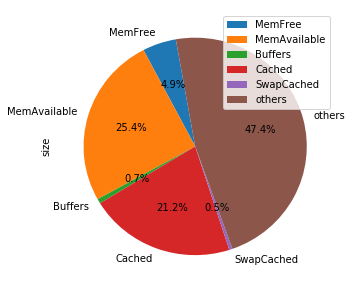

In [31]:
display(lp.log_sections['MEMORY INFO'][:23])

data = list()
sum = 0

for i in range(2,7):
    splited = lp.log_sections['MEMORY INFO'][i].split(':')
    size = int(splited[1].split('kB')[0])
    data.append([splited[0], size])
    sum += size

splited = lp.log_sections['MEMORY INFO'][1].split(':')
total = int(splited[1].split('kB')[0])
data.append(['others', total])

df = pd.DataFrame(data, columns=['id', 'size'])
df = df.set_index('id')

df.plot.pie(y='size',figsize=(5, 5), autopct='%1.1f%%', startangle=100)

plt.show()

In [32]:
lines = lp.log_sections['EVENT LOG']
am_app_dieds = grep(lines,['am_proc_died'], 1)

10-12 20:28:56.175  1000  1048  5029 I am_proc_died: [0,28501,com.samsung.android.app.galaxyfinder:appservice,37,945,20,917,3541]
10-12 20:28:58.266  1000  1048  4693 I am_proc_died: [0,15781,com.samsung.android.easysetup:IcControlService,37,0,11,878,3541]
10-12 20:29:08.511  1000  1048  1068 I am_proc_died: [0,28719,com.samsung.android.app.galaxyfinder:appservice,37,945,20,839,3544]
10-12 20:29:21.181  1000  1048  5029 I am_proc_died: [0,29185,com.samsung.android.app.galaxyfinder:appservice,37,935,20,802,3544]
10-12 20:29:31.810  1000  1048  1328 I am_proc_died: [0,29309,com.samsung.android.app.galaxyfinder:appservice,37,935,20,804,3548]
10-12 20:29:38.002  1000  1048  3046 I am_proc_died: [0,27509,com.samsung.android.dsms,37,999,20,617,3563]
10-12 20:29:38.040  1000  1048  1659 I am_proc_died: [0,27880,com.instagram.android,37,999,20,616,3563]
10-12 20:29:38.210  1000  1048  1659 I am_proc_died: [0,28372,com.instagram.android:videoplayer,37,999,20,632,3563]
10-12 20:29:38.463  1000  

Text(0.5,1,'FREE MEMORY(AM_PROC_DIED)')

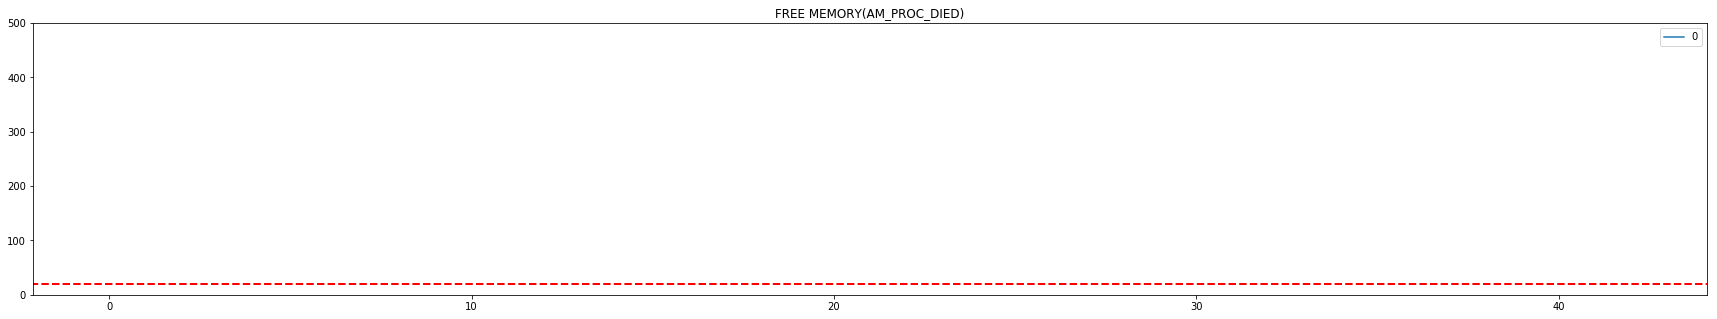

In [33]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-2]))
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0,500))
ax.axhline(y=20, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FREE MEMORY(AM_PROC_DIED)')

In [34]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['WaitForGcToComplete blocked', 'Waiting for a blocking GC Alloc'], 1)

10-12 20:29:07.518  5025 28801 28821 I android.mdx.ki: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 54.189ms
10-12 20:29:07.704  5009 28839 28858 I .android.sclou: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 19.114ms
10-12 20:29:26.626 10078 29309 29328 I nder:appservic: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 14.863ms
10-12 20:29:37.775 10078 29554 29575 I nder:appservic: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 9.733ms
10-12 20:29:39.468  5022 29610 29628 I oid.ipsgeofenc: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 20.457ms
10-12 20:29:39.833 10061 29656 29676 I bluelightfilte: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 42.458ms
10-12 20:29:41.118  1000 29890 29908 I g.accessibilit: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 8.311ms
10-12 20:29:41.581 10066 29977 29997 I pmode.uiservic: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 13.475ms
10-12 20:2

In [35]:
lines = lp.log_sections['EVENT LOG']
am_app_pss_lines = grep(lines,['am_pss', 'am_on_top_resumed_gained_called'], 1, show=False)

for am_app_pss_line in am_app_pss_lines:
    if 'am_pss' in am_app_pss_line:
        am_app_pss_line_splited = am_app_pss_line.split(',')
        pss = am_app_pss_line_splited[-7]
        pss_MB = int(pss) / 1024 / 1024
        if (pss_MB > 50) :
            print(am_app_pss_line + "\t\t\t\t\t// PSS : " + str(pss_MB) + " MB  by " + am_app_pss_line_splited[2])
    else:
        print(am_app_pss_line)

10-12 20:28:55.305 10094 10460 10460 I am_on_top_resumed_gained_called: [0,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,topStateChangedWhenResumed]
10-12 20:29:01.938 10266  3871  3871 I am_on_top_resumed_gained_called: [0,com.samsung.android.voc.diagnosis.hardware.gate.GateActivity,topWhenResuming]
10-12 20:29:07.136 10266  3871  3871 I am_on_top_resumed_gained_called: [0,com.samsung.android.voc.diagnosis.hardware.view.DiagnosisActivity,topStateChangedWhenResumed]
10-12 20:29:10.097  1000  1048  1126 I am_pss  : [27640,10110,com.android.vending,56653824,37580800,1306624,168108032,0,20,12]					// PSS : 54 MB  by com.android.vending
10-12 20:29:10.169  1000  1048  1126 I am_pss  : [27393,10445,com.twitter.android,68183040,59404288,167936,210259968,0,20,16]					// PSS : 65 MB  by com.twitter.android
10-12 20:29:41.804 10094 12799 12799 I am_on_top_resumed_gained_called: [0,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,topStateChangedWhenResume

In [36]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Couldn\'t load memtrack module', 'failed to get memory consumption'], 1)

--- Nothing ---


* If heap free size is 0%, it doubts a memory leak problem.

In [37]:
lines = lp.log_sections['VM TRACES JUST NOW']
heap_lines = grep(lines,['Cmd line:', 'Heap:', 'Total GC', 'Total blocking GC'], 1, show=False)

printable = list()
flag_print = False
for heap_line in heap_lines:
    if 'Cmd line:' in heap_line:
        if flag_print:
            display(printable)
            flag_print = False
        del printable[:]
    printable.append(heap_line)
    if 'Total GC count' in heap_line and re.search('[1-9][0-9][0-9][0-9][0-9]', heap_line):
        flag_print = True
    if 'Heap:' in heap_line and re.search(' [0-9]%', heap_line):
        flag_print = True

['Cmd line: system_server',
 'Heap: 5% free, 89MB/94MB; 1590314 objects',
 'Total GC count: 181',
 'Total GC time: 40.712s',
 'Total blocking GC count: 2',
 'Total blocking GC time: 913.069ms']

['Cmd line: com.sec.android.emergencymode.service',
 'Heap: 4% free, 3549KB/3724KB; 68418 objects',
 'Total GC count: 4',
 'Total GC time: 45.169ms',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.samsung.android.mobileservice',
 'Heap: 3% free, 4527KB/4683KB; 93392 objects',
 'Total GC count: 8',
 'Total GC time: 490.931ms',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

In [38]:
lines = lp.log_sections['LOG STATISTICS']
tmp = grep(lines,['ring buffer is'], 1)

main: ring buffer is 5 MiB (4 MiB consumed), max entry is 5120 B, max payload is 4068 B
radio: ring buffer is 512 KiB (511 KiB consumed), max entry is 5120 B, max payload is 4068 B
events: ring buffer is 256 KiB (241 KiB consumed), max entry is 5120 B, max payload is 4068 B
system: ring buffer is 2 MiB (1 MiB consumed), max entry is 5120 B, max payload is 4068 B
crash: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
stats: ring buffer is 64 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
kernel: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B


* Delay of ION allocation for Camera (100 < duration < 250)

In [39]:
lines = lp.log_sections['SYSTEM LOG']
ION_allocation_lines = grep(lines,['DEBUG:duration time'], 1, show=False)
for ION_allocation_line in ION_allocation_lines:
    if re.search('[0-9][0-9][0-9] msec', ION_allocation_line) or re.search('[0-9][0-9][0-9][0-9] msec', ION_allocation_line):
        print(ION_allocation_line)

10-12 20:30:14.519  1047   541   541 D ExynosCameraInterface: DEBUG:duration time(  106 msec):(HAL3_camera_device_flush)
10-12 20:32:16.552  1047   541 31332 D ExynosCameraSec: DEBUG:duration time(  268 msec):(m_selectBayer)
10-12 20:32:17.089  1047   541 31334 D ExynosCamera: DEBUG:duration time(  500 msec):(m_captureThreadFunc)
10-12 20:32:18.841  1047   541  1237 D ExynosCameraInterface: DEBUG:duration time(  128 msec):(HAL3_camera_device_flush)
10-12 20:32:26.217  1047   541 31397 D ExynosCameraSec: DEBUG:duration time(  415 msec):(m_selectBayer)
10-12 20:32:26.751  1047   541 31398 D ExynosCamera: DEBUG:duration time(  500 msec):(m_captureThreadFunc)


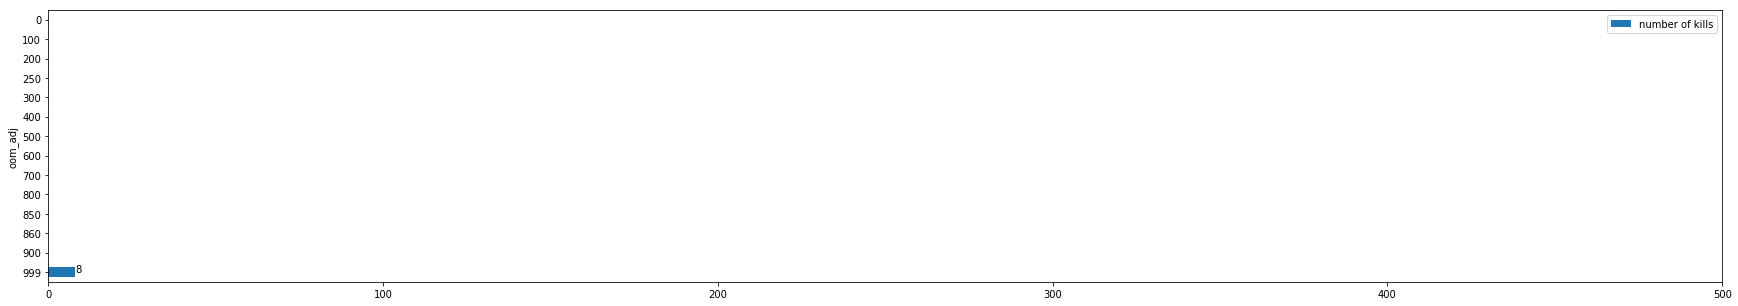

In [40]:
lines = lp.log_sections['ACTIVITY MANAGER LMK KILLS']
oom_adj_lines = grep(lines,['oom_adj'], 1, show=False)

if len(oom_adj_lines) > 0:
    lmk_kills = dict()
    lmk_kills['oom_adj'] = list()
    lmk_kills['number of kills'] = list()

    for oom_adj_line in oom_adj_lines:
        splited = oom_adj_line.split(' ')
        lmk_kills['oom_adj'].append(int(splited[-2][:-1]))
        lmk_kills['number of kills'].append(int(splited[-1]))

    df = pd.DataFrame.from_dict(lmk_kills)
    df.set_index('oom_adj', inplace=True)
    #df.sort_index(ascending=False)

    ax = df.plot(kind='barh', figsize=(30,5), xlim=(0,500))
    for index, value in enumerate(df['number of kills']):
        if value > 0 and value < 500:
            ax.text(value, index, str(value))
    plt.show()

# <span style="color:blue">AP Reset</span> 

* The behaviour of user, likes a term of reboot should be checked.
* MP : Force Reset
* KP : Kernel Panic
* PF_SR (PLATFORM_SILENT_RESET) : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.  
* silent.sec : Automation Restart(Normal Operation)
* PF_EX (PLATFORM_EXCEPTION)

In [41]:
lines = lp.log_sections['AP RESET INFO']
tmp = grep(lines,['AP RESET INFO'])

------ AP RESET INFO (/data/system/users/service/data/RR.p) ------
2020-07-07 10:41:18 |RP|
2020-07-07 16:43:36 |RP| reboot,[SecSettings] Apply new time zo
2020-07-07 17:34:49 |RP| reboot,recovery
2020-07-08 13:29:38 |RP| reboot,userrequested
2020-07-08 22:42:29 |NP| shutdown,userrequested
2020-07-09 17:35:15 |RP| reboot,userrequested
2020-07-11 06:42:53 |RP| lp| NP    | OFFSRC:: PWRHOLD / ONSRC::
2020-07-11 10:38:43 |RP| reboot,userrequested
2020-07-11 22:16:17 |NP| shutdown,userrequested
2020-07-14 10:46:59 |RP| reboot,userrequested
2020-07-14 19:08:41 |RP| reboot,recovery
2020-07-14 19:11:26 |RP| reboot,userrequested
2020-07-25 00:48:51 |NP| shutdown,userrequested
2020-07-25 02:20:47 |RP| lp| NP    | OFFSRC:: PWRHOLD / ONSRC::
2020-07-25 04:50:54 |NP| shutdown,userrequested
2020-07-25 08:12:23 |RP| reboot,userrequested
2020-07-27 19:10:38 |RP| reboot,userrequested
2020-07-29 11:57:18 |NP| shutdown,userrequested
2020-07-30 23:21:55 |RP| reboot,userrequested
2020-07-31 15:22:08 |RP| r

# <span style="color:blue">CRASH</span> 

* In the case of fatal exception, data_app_crash should be confirmed togather.
* In the case of data_app_anr, app launch should be confirmed togather. 
* Crashlytics Exception could not effect to the performance.
* NPE by silent reset : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.

In [42]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['FATAL EXCEPTION', 'Fatal signal'], 4)

--- Nothing ---


In [43]:
lines = lp.log_sections['SERVICE dropbox']
tmp = grep(lines,['system_app_anr', 'system_app_crash', 'data_app_crash', 'data_app_anr', 'system_app_native_crash', 'data_app_native_crash'], 2)

2020-10-11 17:48:15 data_app_native_crash (text, 3991 bytes)
Process: de.bmw.connected.mobile20.row/PID: 22495/UID: 10163/Flags: 0x ...
2020-10-11 21:47:25 system_app_anr (compressed text, 41752 bytes)
Process: com.microsoft.skydrive/PID: 9763/UID: 10113/Flags: 0x30d83ec5 ...
2020-10-11 21:48:30 system_app_anr (compressed text, 43444 bytes)
Process: com.microsoft.skydrive/PID: 9763/UID: 10113/Flags: 0x30d83ec5 ...
2020-10-11 23:37:23 system_app_crash (text, 733 bytes)
Process: com.samsung.android.fmm/PID: 32059/UID: 1000/Flags: 0x10c83e8 ...
2020-10-12 11:02:46 data_app_crash (text, 1162 bytes)
Process: net.teamer.android/PID: 10742/UID: 10447/Flags: 0x3098be44/Pa ...


In [44]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Sending signal'], 1)

10-12 20:29:08.432 10078 28719 28719 I Process : Sending signal. PID: 28719 SIG: 9
10-12 20:29:21.117 10078 29185 29185 I Process : Sending signal. PID: 29185 SIG: 9
10-12 20:29:31.748 10078 29309 29309 I Process : Sending signal. PID: 29309 SIG: 9
10-12 20:30:06.115  5025 28801 28801 I Process : Sending signal. PID: 28801 SIG: 9


# <span style="color:blue">FILE SYSTEM</span> 


* Check whether sdcard is inserted or not.
* Check the available space of media.(It should be remained over 10% at least)

In [45]:
lines = lp.log_sections['FILESYSTEMS & FREE SPACE']
filesystem_lines = grep(lines,['FILESYSTEMS & FREE SPACE'])

------ FILESYSTEMS & FREE SPACE (df) ------
Filesystem                     1K-blocks     Used Available Use% Mounted on
/dev/root                        5654444  5413912    240532  96% /
tmpfs                            3571540     1404   3570136   1% /dev
tmpfs                            3571540        0   3571540   0% /mnt
tmpfs                            3571540        0   3571540   0% /apex
/dev/block/dm-1                   614936   609048      5888 100% /product
/dev/block/dm-2                  1091076  1012192     78884  93% /vendor
tmpfs                            3576756        0   3576756   0% /mnt/sde
/dev/block/sda29                   46288       24     46264   1% /omr
/dev/block/sda28                  596544    16024    580520   3% /cache
/dev/block/sda31               115286604 20149368  95006164  18% /data
/dev/block/sda21                   12008      196     11812   2% /keydata
/dev/block/sda20                   12008      212     11796   2% /keyrefuge
/dev/block/sda7   

* Answer for PLM.

Some applications ( TikTok , Google Photos, Amazon Shopping ) were installed in sdcard in the user's device.<br>
When user entered those apps, It could be delayed.<br>
Please move those apps to the internal sdcard.<br>

/dev/block/dm-7                  9600    83   9517    1% /mnt/asec/com.zhiliaoapp.musically-w19U2VUWNRRfS9yi<br>
/dev/block/dm-8                  4448    23   4425    1% /mnt/asec/com.google.android.apps.photos-u7BcCB7ySRx2Bd4O<br>
/dev/block/dm-10                 5232    35   5197    1% /mnt/asec/com.amazon.mShop.android.shopping-Hys1Miat8tY5nhTH<br>

If the problem will happen again, after treating those apps.<br>
A dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it.<br>
For better analysis, we need the name of application that is related to the issue and the time when it happens.

In [46]:
sdcard_lines = grep(filesystem_lines,['/mnt/asec'])

--- Nothing ---


* SD card insert/remove

[119612.122688] [    kworker/3:2, 14008] mmc0: new ultra high speed SDR104 SDXC card at address 59b4<br>
[119612.132593] [    kworker/3:2, 14008] mmcblk0: mmc0:59b4 USDU1 59.8 GiB

In [47]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['card at address'], 1)

--- Nothing ---


In [48]:
lines = lp.log_sections['STORAGE BUFFER']
tmp = grep(lines,['insertion detected'], 1)

--- Nothing ---


* SD card error

<3>[855725.987054]  [6:   kworker/6:1H:  337] mmc0: Card stuck in wrong state! mmcblk0 card_busy_detect status: 0xf00<br>
<3>[855729.375238]  [6:   kworker/6:1H:  337] Buffer I/O error on dev mmcblk0p1, logical block 3848, lost async page write<br>
<3>[50825.096294]  [0:   kworker/0:2H:11790] mmcblk0: recovery failed!

In [49]:
lines = lp.log_sections['KERNEL LOG']
lines += lp.log_sections['LAST KMSG']
tmp = grep(lines,['card_busy_detect', 'Buffer I/O error', 'Card stuck in wrong state', 'recovery failed', 'mmc_rescan'], 1)

<3>[36288.893286]  [1:    kworker/1:0:17735] mmc0: no detect irq, skipping mmc_rescan
<3>[36290.228838]  [4:    kworker/4:0:17767] mmc0: no detect irq, skipping mmc_rescan


* history of MMC blk0 error

If the count is under 100, it could be happenning during lcd on/off.

In [50]:
lines = lp.log_sections['MMC blk0 error']
display(lines)

[]

09-02 18:58:51.879  root   590 19806 E vold    : exfat -> Filesystem check failed (unknown exit code 8)<br>
09-02 18:58:51.879  root   590 19806 E vold    : public:179,1 failed filesystem check

In [51]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)

--- Nothing ---


# <span style="color:blue">APP LAUNCH TIME</span> 

In [52]:
lines = lp.log_sections['EVENT LOG']
am_app_transitions = grep(lines,['am_app_transition'], 1)

10-12 20:28:56.873  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,WINDOWS_DRAWN,503,-1,121,502,COLD,verify]
10-12 20:29:41.843  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,WINDOWS_DRAWN,197,-1,44,196,COLD,verify]
10-12 20:30:11.064  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,WINDOWS_DRAWN,112,-1,-1,111,WARM,verify]
10-12 20:30:36.712  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,WINDOWS_DRAWN,159,-1,-1,158,WARM,verify]
10-12 20:31:16.133  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,

In [53]:
for am_app_transition in am_app_transitions:
    #for item in am_app_transition.split(','):
    items = am_app_transition.split(',')
    if '.voc' in am_app_transition:
        print('VOC  >>> ' + am_app_transition)
        
    if int(items[-3]) > 1000:
        print('TIME >>> ' + am_app_transition)
        
    if items[-2] == 'COLD':
        print('COLD >>> ' + am_app_transition)

COLD >>> 10-12 20:28:56.873  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,WINDOWS_DRAWN,503,-1,121,502,COLD,verify]
COLD >>> 10-12 20:29:41.843  1000  1048  1126 I am_app_transition: [com.google.android.permissioncontroller,com.android.packageinstaller.permission.ui.GrantPermissionsActivity,WINDOWS_DRAWN,197,-1,44,196,COLD,verify]


In [54]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Displayed'], 1)

10-12 20:29:41.846  1000  1048  1126 I ActivityTaskManager: Displayed com.google.android.permissioncontroller/com.android.packageinstaller.permission.ui.GrantPermissionsActivity: +196ms
10-12 20:30:11.066  1000  1048  1126 I ActivityTaskManager: Displayed com.google.android.permissioncontroller/com.android.packageinstaller.permission.ui.GrantPermissionsActivity: +111ms
10-12 20:30:36.716  1000  1048  1126 I ActivityTaskManager: Displayed com.google.android.permissioncontroller/com.android.packageinstaller.permission.ui.GrantPermissionsActivity: +158ms
10-12 20:31:16.137  1000  1048  1126 I ActivityTaskManager: Displayed com.google.android.permissioncontroller/com.android.packageinstaller.permission.ui.GrantPermissionsActivity: +107ms
10-12 20:31:19.415  1000  1048  1126 I ActivityTaskManager: Displayed com.google.android.permissioncontroller/com.android.packageinstaller.permission.ui.GrantPermissionsActivity: +88ms
10-12 20:31:22.547  1000  1048  1126 I ActivityTaskManager: Displayed c

In [55]:
lines = lp.log_sections['OLOG']
tmp = grep(lines,['APPLAUNCH', 'LCDV'], 1)

[10-12 20:23:31.024 2  1048     0 ( 38)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [S]
[10-12 20:23:31.028 2  1048     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[10-12 20:23:40.479 1  1048     0 (  3)][LOG][LCDV] OFF
[10-12 20:23:45.578 1  1048     0 (  2)][LOG][LCDV] ON
[10-12 20:23:51.733 2  1048     0 ( 46)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [20710] [E]
[10-12 20:23:56.454 2  1048     0 ( 55)][EVT][APPLAUNCH] com.sec.android.emergencylauncher/.LauncherActivity [S]
[10-12 20:23:56.454 2  1048     0 ( 37)][EVT][APPLAUNCH] com.sec.android.emergencylauncher [C]
[10-12 20:23:57.497 2  1048     0 ( 62)][EVT][APPLAUNCH] com.sec.android.emergencylauncher/.LauncherActivity [1043] [E]
[10-12 20:23:58.641 1  1048     0 (129)][LOG][APPLAUNCH] [com.sec.android.emergencylauncher],com.sec.android.emergencylauncher.LauncherActivity,SPLASH_SCREEN,536,488,398,1460,COLD,verify
[10-12 20:24:17.530 2  1048     0 ( 61)][EVT][APPLAUNCH] com.sec.android.app.launcher/.activ

# <span style="color:blue">KEYBOARD</span> 
* Open and close keybboard

In [56]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['HoneyBoardService onWindow'], 1)

10-12 20:33:23.246 10249  7702  7702 I HONEYBOARD: HoneyBoardService onWindowShown
10-12 20:34:21.929 10249  7702  7702 I HONEYBOARD: HoneyBoardService onWindowHidden


* Honeyboard issue with this logs.<br>
[KeyboardContainer] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed

In [57]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['do not send BoardScrap cause by layout is not changed'], 1)

10-12 20:33:23.308 10249  7702  7702 W HONEYBOARD: b [PresenterContainerImpl] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed
10-12 20:33:24.531 10249  7702  7702 W HONEYBOARD: b [PresenterContainerImpl] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed
10-12 20:33:24.587 10249  7702  7702 W HONEYBOARD: b [PresenterContainerImpl] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed
10-12 20:33:24.659 10249  7702  7702 W HONEYBOARD: b [PresenterContainerImpl] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed
10-12 20:33:24.677 10249  7702  7702 W HONEYBOARD: b [PresenterContainerImpl] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed
10-12 20:33:24.770 10249  7702  7702 W HONEYBOARD: b [PresenterContainerImpl] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed
10-12 20:33:24.840 10249  7702  7702 W HONEYBOARD: b [PresenterC

In [58]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['App Policy disabled'], 1)

10-12 20:33:24.606 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:24.686 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:24.825 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:25.723 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:25.867 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:25.910 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:26.011 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:26.116 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:26.762 10249  7702 12008 I HONEYBOARD: a [RTS] App Policy disabled : com.samsung.android.voc
10-12 20:33:26.822 10249  7702 12008 I HONEYBOARD: a [R

In [59]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setNetworkState error currentNetworkCapabilities is null '], 1)

--- Nothing ---


# <span style="color:blue">INPUT</span> 

* InputDispatcher error log

In [60]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_input', '@Sync'], 1)

<6>[  345.240481]  [0: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:0.120 z:60 major:15 minor:15 loc:C.C tc:1 type:0 noise:0,0
<6>[  345.297155]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:-15,-2 mp:0,0 mc:5 tc:0 p:0 noise:0
<6>[  346.167853]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:0.121 z:47 major:12 minor:12 loc:C.C tc:1 type:0 noise:0,0
<6>[  346.176063]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] sec_ts_read_event: FOD: PRESS
<6>[  346.234330]  [1: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:1,1 mp:0,0 mc:2 tc:0 p:0 noise:0
<6>[  346.825374]  [7:tspStateManager:28820] [sec_input] sec_cmd_store: push cmd: set_grip_data,1,60,10,32,912
<6>[  346.825391]  [7:tspStateManager:28820] [sec_input] sec_cmd_store_function: cmd = set_grip_data param = 1 60 10 32 912
<6>[  346.825413]  [7:tspStateManager:28820] sec_ts 4-0048: [sec_input] set_grip_data_to_ic: flag: 04 (clr,lan,nor,edg,han)
<6>[  

<6>[  345.240481]  [0: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:0.120 z:60 major:15 minor:15 loc:C.C tc:1 type:0 noise:0,0
<6>[  345.297155]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:-15,-2 mp:0,0 mc:5 tc:0 p:0 noise:0
<6>[  351.045649]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:1.122 z:52 major:13 minor:13 loc:C.C tc:1 type:0 noise:0,0
<6>[  351.121073]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:1 loc:C.C dd:-2,3 mp:4,5 mc:7 tc:0 p:0 noise:0
<6>[  500.978357]  [2: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:2.172 z:40 major:10 minor:10 loc:E.S tc:2 type:0 noise:0,0
<6>[  501.004028]  [2: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:2 loc:E.C dd:88,177 mp:0,0 mc:2 tc:1 p:0 noise:0
<6>[36165.452479]  [2: irq/431-sec_ts:  216] sec_ts 4-0048: [sec_input] [P] tID:3.19361 z:37 major:9 minor:9 loc:C.C tc:1 type:0 noise:0,0
<6>[36165.485901]  [3: irq/431-sec_ts:  216] sec_ts 4-0048:

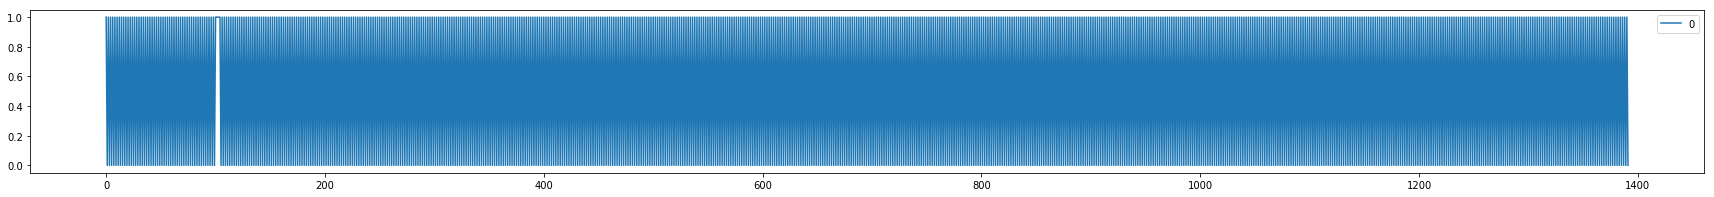

tID : 1,     Count of press : 69,  Count of release : 69


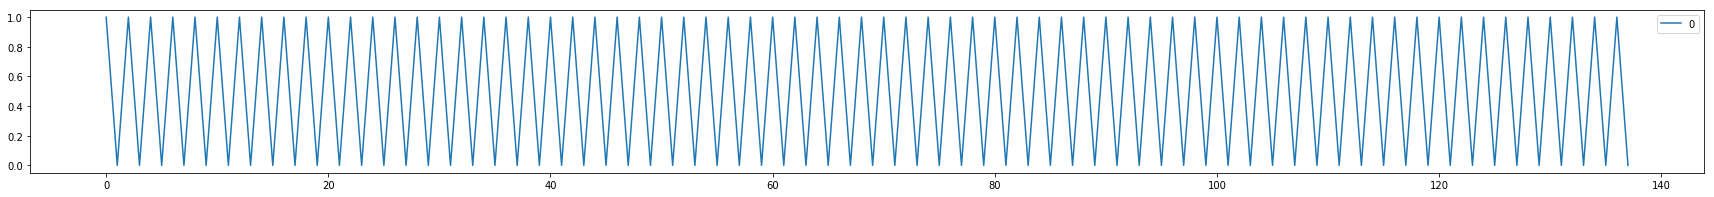

tID : 2,     Count of press : 30,  Count of release : 30


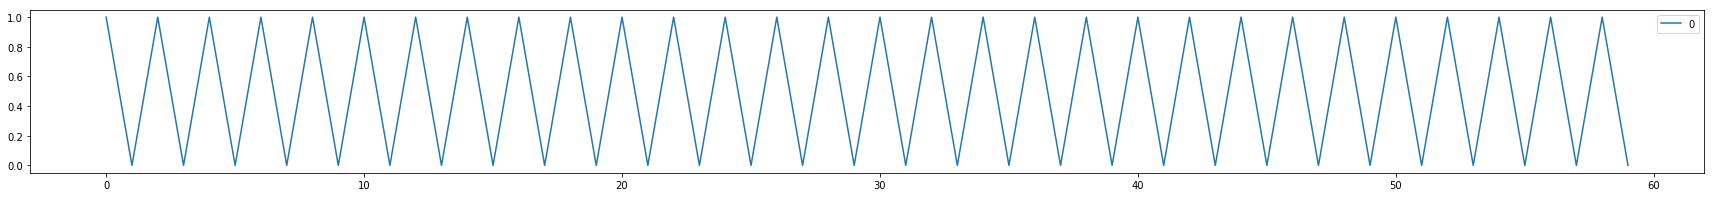

tID : 3,     Count of press : 6,  Count of release : 6


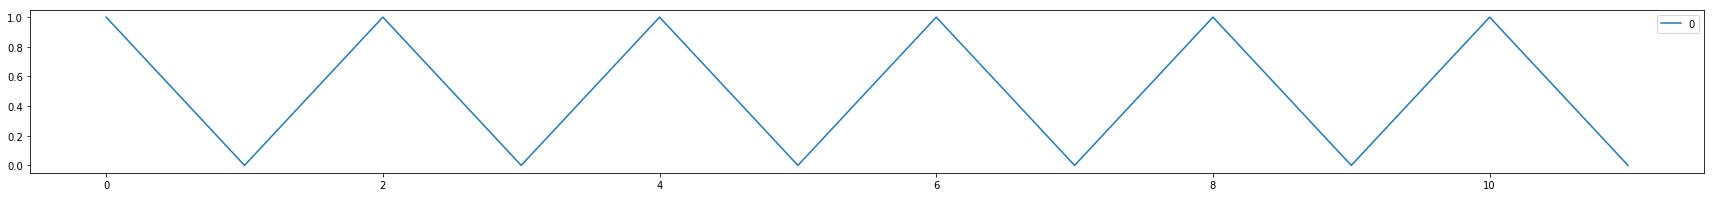

In [61]:
tID_list = dict()
tID_cur = dict()
tID_press = dict()
tID_release = dict()

for sec_input_line in sec_input_lines:
    if 'tID:' in sec_input_line:
        #print(sec_input_line)
        splited_sec_input = sec_input_line.split('tID:')[1]
        numbers = re.findall('\d+', splited_sec_input)
        tID = int(numbers[0])
        
        #display(tID)
        if tID not in tID_list:
            tID_list[tID] = list()
        if tID not in tID_cur:
            tID_cur[tID] = 0
        if tID not in tID_press:
            tID_press[tID] = 0
        if tID not in tID_release:
            tID_release[tID] = 0          

        if '[P]' in sec_input_line:
            tID_cur[tID] += 1
            tID_press[tID] += 1
        elif '[R]' in sec_input_line:
            tID_cur[tID] -= 1
            tID_release[tID] += 1

        if tID_cur[tID] not in tID_list[tID]:
            print(sec_input_line)

        tID_list[tID].append(tID_cur[tID])

print('\n\n')
for key in tID_list.keys():
    print('tID : {},     Count of press : {},  Count of release : {}'.format(key, tID_press[key], tID_release[key]))
    pd.DataFrame(tID_list[key]).plot(figsize=(30,3))
    plt.show()

* The count of noise in sec_input log should be kept with zero.

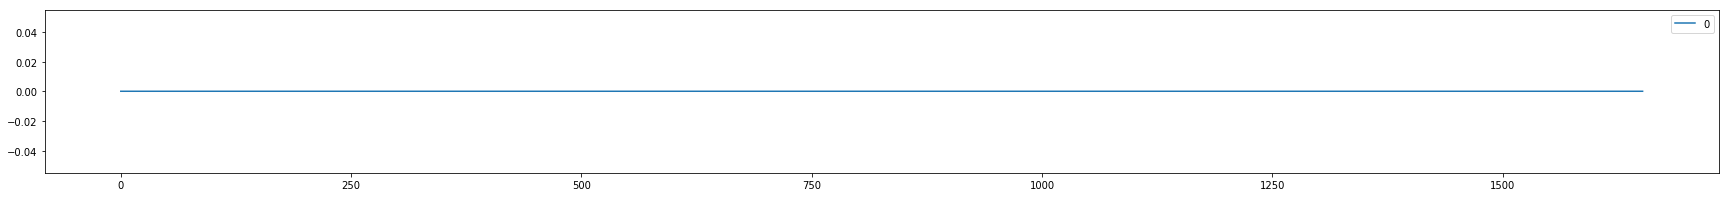

In [62]:
sec_input_noise = list()

for sec_input_line in sec_input_lines:
    #print(sec_input_line)
    if 'noise:(' in sec_input_line:
        #print(sec_input_line.split('noise:(')[1])
        number_of_noise = int(sec_input_line.split('noise:(')[1].split(',')[0])
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
    elif 'noise:' in sec_input_line:
        #print(sec_input_line.split('noise:')[1])
        try:
            number_of_noise = int(sec_input_line.split('noise:')[1].split(',')[0])
        except:
            number_of_noise = int(sec_input_line.split('noise:')[1].split(' ')[0])
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
if len(sec_input_noise):
    df = pd.DataFrame(sec_input_noise)
    df.plot(figsize=(30,3))
else:
    print('---No data---')

In [63]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['InputReader', 'InputDispatcher:', 'Found dropped events'], 1)

10-12 20:29:06.608  1000  1048  1305 I InputReader: Reconfiguring input devices.  changes=0x00000010
10-12 20:29:06.673  1000  1048  1305 D InputReader: Btn_touch(8): value=1 when=351.027544
10-12 20:29:06.674  1000  1048  1305 I InputReader: Touch event's action is 0x0 (id=8, t=0) [pCnt=1, s=1.122 ] when=351.027544
10-12 20:29:06.674  1000  1048  1304 I InputDispatcher: Delivering touch to (1507): action: 0x4, f=0x0, d=0, 'ae0476c', t=1
10-12 20:29:06.674  1000  1048  1304 I InputDispatcher: Delivering touch to (1507): action: 0x4, f=0x0, d=0, 'db83318', t=1
10-12 20:29:06.674  1000  1048  1304 I InputDispatcher: Delivering touch to (3871): action: 0x0, f=0x0, d=0, '16ad03b', t=1
10-12 20:29:06.749  1000  1048  1305 D InputReader: Btn_touch(8): value=0 when=351.102969
10-12 20:29:06.749  1000  1048  1305 I InputReader: Touch event's action is 0x1 (id=8, t=0) [pCnt=1, s=] when=351.102969
10-12 20:29:06.749  1000  1048  1304 I InputDispatcher: Delivering touch to (3871): action: 0x1, f=

* Volume up : InputReader: Input event: ... code=114
* Volume dn : InputReader: Input event: ... code=115
* Power key : InputReader: Input event: ... code=116 
* Touch key is same with normal touch.

In [64]:
def printandinit():
    if checklog['kernel'] is False:
        print('>>>>> KERNEL LOG is missing!!! <<<<<')

    if checklog['reader'] is False:
        print('>>>>> InputReader LOG is missing!!! <<<<<')

    if checklog['dispatcher'] is False:
        print('>>>>> InputDispatcher LOG is missing!!! <<<<<')

    checklog['kernel'] = False
    checklog['reader'] = False
    checklog['dispatcher'] = False

lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader'], 1, show=False)

lines = lp.log_sections['KERNEL LOG']
kernel_sec_inputs = grep(lines,['sec_input', '@Sync'], 1, show=False)

idx_reader_dispatcher = 0
idx_sec_input = 0

checklog = dict()
checklog['kernel'] = False
checklog['reader'] = False
checklog['dispatcher'] = False

sync_time = None
sync_kernel_log = None

while True:
    if idx_sec_input >= len(kernel_sec_inputs):
        break
    
    if idx_reader_dispatcher >= len(Reader_Dispatchers):
        break

    reader_dispatcher = Reader_Dispatchers[idx_reader_dispatcher]
    kernel_sec_input = kernel_sec_inputs[idx_sec_input]
    
    if '@Sync' in kernel_sec_input:
        androidtime = GetTime(kernel_sec_input)
        kerneltime = GetKernelTime(kernel_sec_input)

        if androidtime >= 0 and kerneltime >= 0:
            GAP_OF_TIME = androidtime - kerneltime
            sync_time = '[ SYNC {} = {} - {} ]'.format(GAP_OF_TIME, androidtime, kerneltime)
            sync_kernel_log = kernel_sec_input
        
        idx_sec_input += 1
        if idx_sec_input >= len(kernel_sec_inputs):
            break
        kernel_sec_input = kernel_sec_inputs[idx_sec_input]
            
    
    reader_dispatcher_time = GetTime(reader_dispatcher)
    if '[P]' in kernel_sec_input or '[R]' in kernel_sec_input or ' 114,' in kernel_sec_input or ' 115,' in kernel_sec_input or ' 116,' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    elif 'Finger' in kernel_sec_input or 'gpio_keys_gpio_report_event' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    else:
        idx_sec_input += 1
        continue
    
    if reader_dispatcher_time < kernel_sec_input_time:
        if 'InputReader' in reader_dispatcher:
            checklog['reader'] = True
            if checklog['kernel'] is False:
                if 'Btn_touch' in reader_dispatcher or 'Input event' in reader_dispatcher:
                    printandinit()
                    print("")
        if 'InputDispatcher' in reader_dispatcher:
            checklog['dispatcher'] = True
        print("{} - {}".format(reader_dispatcher_time, reader_dispatcher))
        idx_reader_dispatcher += 1
    else:
        printandinit()

        if sync_time is not None:
            print("")
            print(sync_time)
            print(sync_kernel_log)
            sync_time = None

        print("")
        if ' 114,' in kernel_sec_input:
            print("[[[ VOL UP KEY ]]]")
        elif ' 115,' in kernel_sec_input:
            print("[[[ VOL DN KEY ]]]")
        elif ' 116,' in kernel_sec_input:
            print("[[[ POWER KEY ]]]")
        print("{} - {}".format(kernel_sec_input_time, kernel_sec_input))
        idx_sec_input += 1
        checklog['kernel'] = True

>>>>> KERNEL LOG is missing!!! <<<<<
>>>>> InputReader LOG is missing!!! <<<<<
>>>>> InputDispatcher LOG is missing!!! <<<<<

27894540867 - <6>[  345.240481]  [0: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:0.120 z:60 major:15 minor:15 loc:C.C tc:1 type:0 noise:0,0
>>>>> InputReader LOG is missing!!! <<<<<
>>>>> InputDispatcher LOG is missing!!! <<<<<

27894540924 - <6>[  345.297155]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:-15,-2 mp:0,0 mc:5 tc:0 p:0 noise:0
>>>>> InputReader LOG is missing!!! <<<<<
>>>>> InputDispatcher LOG is missing!!! <<<<<

27894541794 - <6>[  346.167853]  [3: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [P] tID:0.121 z:47 major:12 minor:12 loc:C.C tc:1 type:0 noise:0,0
>>>>> InputReader LOG is missing!!! <<<<<
>>>>> InputDispatcher LOG is missing!!! <<<<<

27894541861 - <6>[  346.234330]  [1: irq/431-sec_ts:  214] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:1,1 mp:0,0 mc:2 tc:0 p:0 noise:0
27894546608 - 10-1

In [65]:
Reader_Dispatchers = grep(lines,['Touch event\'s action is'], 1, show=False)
for line in Reader_Dispatchers:
    if 'Btn_touch' in line:
        print('')
    print(line)

--- Nothing ---


In [66]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD'], 1)

--- Nothing ---


* Touch HW error<br>
ex) An error occured at Rx36<br>
[    5.247112] sec_ts 2-0048 : Rx34 |  307 319 320 322 327 327 328 333 334 332 329 327 326 323 321 319 324<br>
[    5.247129] sec_ts 2-0048 : Rx35 |  313 325 327 329 333 333 335 340 342 340 337 335 333 331 329 325 330<br>
[    5.247146] sec_ts 2-0048 : Rx36 |   -1   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0<br>
[    5.247163] sec_ts 2-0048 : Rx37 |  207 254 256 258 261 261 262 268 226 268 264 262 261 259 257 255 228<br>

In [67]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_ts'], 1, show=False)
lines = lp.log_sections['TSP RAW DATA']
sec_input_lines += grep(lines,['sec_ts'], 1, show=False)

x = list()
x_ = list()
for sec_input_line in sec_input_lines:
    if re.search("Rx00", sec_input_line):
        if len(x_) > 0:
            x.append(x_)
            x_ = list()
            print("")
    if re.search("Rx[0-9][0-9]", sec_input_line):
        print(sec_input_line)
        splited = sec_input_line.split('|')
        if len(splited) > 0:
            splited_items = splited[1].split(' ')
            for splited_item in splited_items:
                if len(splited_item) > 0:
                    x_.append(int(splited_item))
x.append(x_)

[    3.297978] sec_ts 4-0048 : Rx00 |   57  71  63  61  70  68  74  76  73  73  70  65  63  63  70  65
[    3.298006] sec_ts 4-0048 : Rx01 |   63  55  47  37  43  42  43  45  42  42  41  34  34  40  50  64
[    3.298022] sec_ts 4-0048 : Rx02 |   56  44  32  20  25  21  20  18  18  17  15  14  18  20  30  55
[    3.298038] sec_ts 4-0048 : Rx03 |   46  32  14   8  10   4   2   2   0  -2  -1   0  10  13  26  52
[    3.298053] sec_ts 4-0048 : Rx04 |   44  24  12   0   2  -4  -4  -4  -4  -9  -7  -7   7  11  29  77
[    3.298068] sec_ts 4-0048 : Rx05 |   46  26  12  -3   0  -6  -6  -6 -11  -7 -11  -7   7  13  39 113
[    3.298089] sec_ts 4-0048 : Rx06 |   40  20   9  -3   0  -4  -4  -5  -6  -6  -7  -5   4  14  38 114
[    3.298104] sec_ts 4-0048 : Rx07 |   32  15   5  -7  -6  -4  -6 -10  -9 -11 -11  -9  -3   7  29 103
[    3.298185] sec_ts 4-0048 : Rx08 |   28  13   3 -11  -6  -8  -8 -10 -10 -12 -14  -9  -1   4  24  67
[    3.298213] sec_ts 4-0048 : Rx09 |   29  16   4  -6  -3  -5  -5  -9 -1

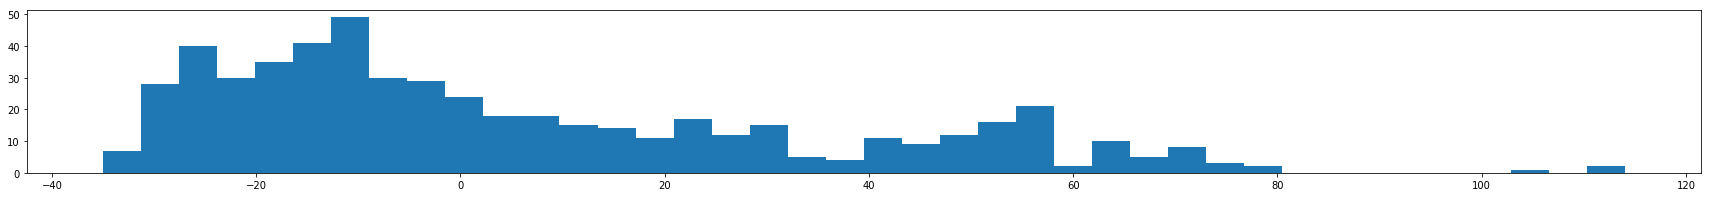

mean : 6.04779411765,  standard deviation : 29.9121494766


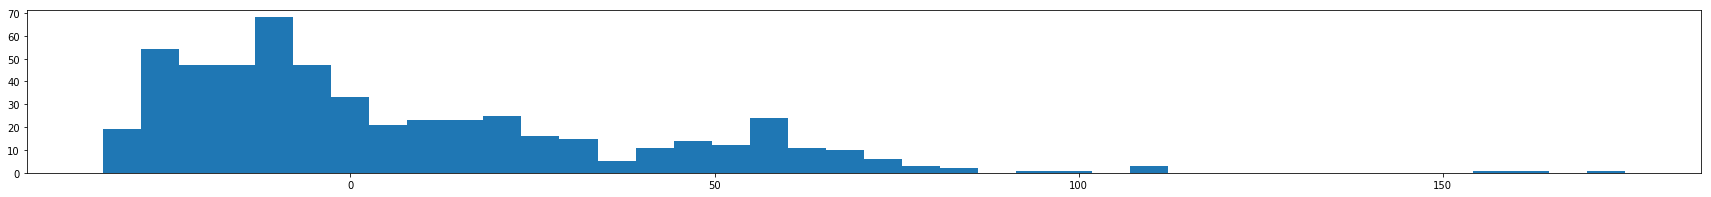

mean : 7.22426470588,  standard deviation : 32.4899486636


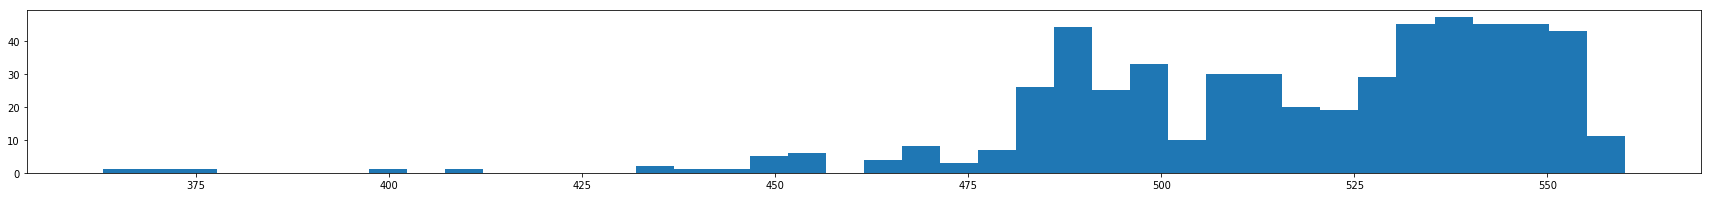

mean : 517.459558824,  standard deviation : 29.8390015176


In [68]:
for x_ in x:
    plt.figure(figsize=(30, 3))
    plt.hist(x_, bins = 40)
    plt.show()

    arr = np.array(x_)
    print("mean : {},  standard deviation : {}".format(arr.mean(), arr.std()))

# <span style="color:blue">LOCKs</span> 

* If 'dalvik.vm.lockprof.threshold' property is not exist, lock monitor contention is off.

In [69]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['dalvik.vm.lockprof.threshold'], 1)

[dalvik.vm.lockprof.threshold]: [500]
